In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from qiskit import QuantumCircuit
from qiskit.visualization.bloch import Bloch
#from IPython.display import HTML, Image

In [2]:
dir(Bloch)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_annotation',
 'add_points',
 'add_vectors',
 'clear',
 'make_sphere',
 'plot_annotations',
 'plot_axes',
 'plot_axes_labels',
 'plot_back',
 'plot_front',
 'plot_points',
 'plot_vectors',
 'render',
 'save',
 'set_label_convention',
 'show']

In [12]:
import sys
from math import sin, cos, acos, sqrt
import numpy as np


def _normalize(v, tolerance=0.00001):
    """Makes sure magnitude of the vector is 1 with given tolerance"""

    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = sqrt(mag2)
        v = tuple(n / mag for n in v)
    return np.array(v)


class _Quaternion:
    """For calculating vectors on unit sphere"""
    def __init__(self):
        self._val = None

    @staticmethod
    def from_axisangle(theta, v):
        """Create quaternion from axis"""
        v = _normalize(v)

        new_quaternion = _Quaternion()
        new_quaternion._axisangle_to_q(theta, v)
        return new_quaternion

    @staticmethod
    def from_value(value):
        """Create quaternion from vector"""
        new_quaternion = _Quaternion()
        new_quaternion._val = value
        return new_quaternion

    def _axisangle_to_q(self, theta, v):
        """Convert axis and angle to quaternion"""
        x = v[0]
        y = v[1]
        z = v[2]

        w = cos(theta/2.)
        x = x * sin(theta/2.)
        y = y * sin(theta/2.)
        z = z * sin(theta/2.)

        self._val = np.array([w, x, y, z])

    def __mul__(self, b):
        """Multiplication of quaternion with quaternion or vector"""

        if isinstance(b, _Quaternion):
            return self._multiply_with_quaternion(b)
        elif isinstance(b, (list, tuple, np.ndarray)):
            if len(b) != 3:
                raise Exception("Input vector has invalid length {}".format(len(b)))
            return self._multiply_with_vector(b)
        else:
            raise Exception("Multiplication with unknown type {}".format(type(b)))

    def _multiply_with_quaternion(self, q_2):
        """Multiplication of quaternion with quaternion"""
        w_1, x_1, y_1, z_1 = self._val
        w_2, x_2, y_2, z_2 = q_2._val
        w = w_1 * w_2 - x_1 * x_2 - y_1 * y_2 - z_1 * z_2
        x = w_1 * x_2 + x_1 * w_2 + y_1 * z_2 - z_1 * y_2
        y = w_1 * y_2 + y_1 * w_2 + z_1 * x_2 - x_1 * z_2
        z = w_1 * z_2 + z_1 * w_2 + x_1 * y_2 - y_1 * x_2

        result = _Quaternion.from_value(np.array((w, x, y, z)))
        return result

    def _multiply_with_vector(self, v):
        """Multiplication of quaternion with vector"""
        q_2 = _Quaternion.from_value(np.append((0.0), v))
        return (self * q_2 * self.get_conjugate())._val[1:]

    def get_conjugate(self):
        """Conjugation of quaternion"""
        w, x, y, z = self._val
        result = _Quaternion.from_value(np.array((w, -x, -y, -z)))
        return result

    def __repr__(self):
        theta, v = self.get_axisangle()
        return "(({}; {}, {}, {}))".format(theta, v[0], v[1], v[2])

    def get_axisangle(self):
        """Returns angle and vector of quaternion"""
        w, v = self._val[0], self._val[1:]
        theta = acos(w) * 2.0

        return theta, _normalize(v)

    def tolist(self):
        """Converts quaternion to a list"""
        return self._val.tolist()

    def vector_norm(self):
        """Calculates norm of quaternion"""
        _, v = self.get_axisangle()
        return np.linalg.norm(v)


def visualize_transition(circuit,
                         trace=False,
                         saveas=None,
                         fpg=100,
                         spg=2):
    """
    Creates animation showing transitions between states of a single
    qubit by applying quantum gates.

    Args:
        circuit (QuantumCircuit): Qiskit single-qubit QuantumCircuit. Gates supported are
            h,x, y, z, rx, ry, rz, s, sdg, t, tdg and u1.
        trace (bool): Controls whether to display tracing vectors - history of 10 past vectors
            at each step of the animation.
        saveas (str): User can choose to save the animation as a video to their filesystem.
            This argument is a string of path with filename and extension (e.g. "movie.mp4" to
            save the video in current working directory).
        fpg (int): Frames per gate. Finer control over animation smoothness and computational
            needs to render the animation. Works well for tkinter GUI as it is, for jupyter GUI
            it might be preferable to choose fpg between 5-30.
        spg (int): Seconds per gate. How many seconds should animation of individual gate
            transitions take.

    Returns:
        IPython.core.display.HTML:
            If arg jupyter is set to True. Otherwise opens tkinter GUI and returns
            after the GUI is closed.

    Raises:
        ImportError: Must have Matplotlib (and/or IPython) installed.
        VisualizationError: Given gate(s) are not supported.

    """
    try:
        from IPython.display import HTML
        has_ipython = True
    except ImportError:
        has_ipython = False

    try:
        import matplotlib
        from matplotlib import pyplot as plt
        from matplotlib import animation
        from mpl_toolkits.mplot3d import Axes3D
        from qiskit.visualization.bloch import Bloch
        from qiskit.visualization.exceptions import VisualizationError
        has_matplotlib = True
    except ImportError:
        has_matplotlib = False

    jupyter = False
    if ('ipykernel' in sys.modules) and ('spyder' not in sys.modules):
        jupyter = True

    if not has_matplotlib:
        raise ImportError("Must have Matplotlib installed.")
    if not has_ipython and jupyter is True:
        raise ImportError("Must have IPython installed.")
    if len(circuit.qubits) != 1:
        raise VisualizationError("Only one qubit circuits are supported")

    frames_per_gate = fpg
    time_between_frames = (spg*1000)/fpg

    # quaternions of gates which don't take parameters
    gates = dict()
    gates['x'] = ('x', _Quaternion.from_axisangle(np.pi / frames_per_gate, [1, 0, 0]), '#1abc9c')
    gates['y'] = ('y', _Quaternion.from_axisangle(np.pi / frames_per_gate, [0, 1, 0]), '#2ecc71')
    gates['z'] = ('z', _Quaternion.from_axisangle(np.pi / frames_per_gate, [0, 0, 1]), '#3498db')
    gates['s'] = ('s', _Quaternion.from_axisangle(np.pi / 2 / frames_per_gate,
                                                  [0, 0, 1]), '#9b59b6')
    gates['sdg'] = ('sdg', _Quaternion.from_axisangle(-np.pi / 2 / frames_per_gate, [0, 0, 1]),
                    '#8e44ad')
    gates['h'] = ('h', _Quaternion.from_axisangle(np.pi / frames_per_gate, _normalize([1, 0, 1])),
                  '#34495e')
    gates['t'] = ('t', _Quaternion.from_axisangle(np.pi / 4 / frames_per_gate, [0, 0, 1]),
                  '#e74c3c')
    gates['tdg'] = ('tdg', _Quaternion.from_axisangle(-np.pi / 4 / frames_per_gate, [0, 0, 1]),
                    '#c0392b')

    implemented_gates = ['h', 'x', 'y', 'z', 'rx', 'ry', 'rz', 's', 'sdg', 't', 'tdg', 'u1']
    simple_gates = ['h', 'x', 'y', 'z', 's', 'sdg', 't', 'tdg']
    list_of_circuit_gates = []

    for gate in circuit._data:
        if gate[0].name not in implemented_gates:
            raise VisualizationError("Gate {} is not supported".format(gate[0].name))
        if gate[0].name in simple_gates:
            list_of_circuit_gates.append(gates[gate[0].name])
        else:
            theta = gate[0].params[0]
            if gate[0].name == 'rx':
                quaternion = _Quaternion.from_axisangle(theta / frames_per_gate, [1, 0, 0])
                list_of_circuit_gates.append(('rx:'+str(theta), quaternion, '#16a085'))
            elif gate[0].name == 'ry':
                quaternion = _Quaternion.from_axisangle(theta / frames_per_gate, [0, 1, 0])
                list_of_circuit_gates.append(('ry:'+str(theta), quaternion, '#27ae60'))
            elif gate[0].name == 'rz':
                quaternion = _Quaternion.from_axisangle(theta / frames_per_gate, [0, 0, 1])
                list_of_circuit_gates.append(('rz:'+str(theta), quaternion, '#2980b9'))
            elif gate[0].name == 'u1':
                quaternion = _Quaternion.from_axisangle(theta / frames_per_gate, [0, 0, 1])
                list_of_circuit_gates.append(('u1:'+str(theta), quaternion, '#f1c40f'))

    if len(list_of_circuit_gates) == 0:
        raise VisualizationError("Nothing to visualize.")

    starting_pos = _normalize(np.array([0, 0, 1]))

    fig = plt.figure(figsize=(10, 10))
    _ax = Axes3D(fig)
    _ax.set_xlim(-10, 10)
    _ax.set_ylim(-10, 10)
    sphere = Bloch(axes=_ax)

    class Namespace:
        """Helper class serving as scope container"""
        def __init__(self):
            self.new_vec = []
            self.last_gate = -2
            self.colors = []
            self.pnts = []

    namespace = Namespace()
    namespace.new_vec = starting_pos

    def animate(i):
        sphere.clear()

        # starting gate count from -1 which is the initial vector
        gate_counter = (i-1) // frames_per_gate
        if gate_counter != namespace.last_gate:
            namespace.pnts.append([[], [], []])
            namespace.colors.append(list_of_circuit_gates[gate_counter][2])

        # starts with default vector [0,0,1]
        if i == 0:
            sphere.add_vectors(namespace.new_vec)
            namespace.pnts[0][0].append(namespace.new_vec[0])
            namespace.pnts[0][1].append(namespace.new_vec[1])
            namespace.pnts[0][2].append(namespace.new_vec[2])
            namespace.colors[0] = 'r'
            sphere.make_sphere()
            return _ax

        namespace.new_vec = list_of_circuit_gates[gate_counter][1] * namespace.new_vec

        namespace.pnts[gate_counter+1][0].append(namespace.new_vec[0])
        namespace.pnts[gate_counter+1][1].append(namespace.new_vec[1])
        namespace.pnts[gate_counter+1][2].append(namespace.new_vec[2])

        sphere.add_vectors(namespace.new_vec)
        if trace:
            # sphere.add_vectors(namespace.points)
            for point_set in namespace.pnts:
                sphere.add_points([point_set[0], point_set[1], point_set[2]])

        sphere.vector_color = [list_of_circuit_gates[gate_counter][2]]
        sphere.point_color = namespace.colors
        sphere.point_marker = 'o'

        annotation_text = list_of_circuit_gates[gate_counter][0]
        annotationvector = [1.4, -0.45, 1.7]
        sphere.add_annotation(annotationvector,
                              annotation_text,
                              color=list_of_circuit_gates[gate_counter][2],
                              fontsize=30,
                              horizontalalignment='left')

        sphere.make_sphere()

        namespace.last_gate = gate_counter
        return _ax

    def init():
        sphere.vector_color = ['r']
        return _ax

    ani = animation.FuncAnimation(fig,
                                  animate,
                                  range(frames_per_gate * len(list_of_circuit_gates)+1),
                                  init_func=init,
                                  blit=False,
                                  repeat=False,
                                  interval=time_between_frames)

    if saveas:
        ani.save(saveas, fps=30)
    if jupyter:
        # This is necessary to overcome matplotlib memory limit
        matplotlib.rcParams['animation.embed_limit'] = 50
        return HTML(ani.to_jshtml())
    plt.show()
    plt.close(fig)
    return None

In [13]:

def t1(angle,*, z=0):
    
    

    if (0 <= angle < np.pi / 2) or (np.pi <= angle < 3 * np.pi / 2):
        return (1 / 2) * np.arctan2(
            ((-1)**z)*np.sqrt(np.sin(2 * angle)) / (np.cos(angle) + np.sin(angle)),
            1 / (np.cos(angle) + np.sin(angle)),
        )
    
    if (np.pi / 2 <= angle < np.pi) or (3 * np.pi / 2 <= angle < 2 * np.pi):
        return (1 / 2) * np.arctan2(
            - ((-1)**z)*(np.sqrt(-np.sin(2 * angle)) / (np.cos(angle) - np.sin(angle))),
            1 / (np.cos(angle) - np.sin(angle)),
        )
      
        
  

def t2(angle,*, z=0):
    

    if (0 <= angle < np.pi / 2) or (np.pi <= angle < 3 * np.pi / 2):
        
        return (1 / 2) * np.arctan2(
                            - ((-1)**z)*np.sqrt(np.sin(2 * angle)),
                                np.cos(angle) - np.sin(angle)
                                    )
    
    if (np.pi / 2 <= angle < np.pi) or (3 * np.pi / 2 <= angle < 2 * np.pi):
       
        return (1 / 2) * np.arctan2(
            - ((-1)**z)*np.sqrt(-np.sin(2 * angle)),
            np.cos(angle) + np.sin(angle)
        )
        

In [16]:
t = 0.01

#Phasecraft circuit
pc_circuit = QuantumCircuit(1)


pc_circuit.ry(0.1, 0)
pc_circuit.rx(0.1, 0)

pc_circuit.ry(2*t1(t), 0)
pc_circuit.rx(2*t2(t), 0)
pc_circuit.ry(2*t2(t), 0)
pc_circuit.rx(2*t1(t), 0)

#standard circuit
st_circuit = QuantumCircuit(1)


st_circuit.ry(np.pi/2, 0)
st_circuit.rx(2*t, 0)
st_circuit.ry(-np.pi/2, 0)







IndexError: list index out of range

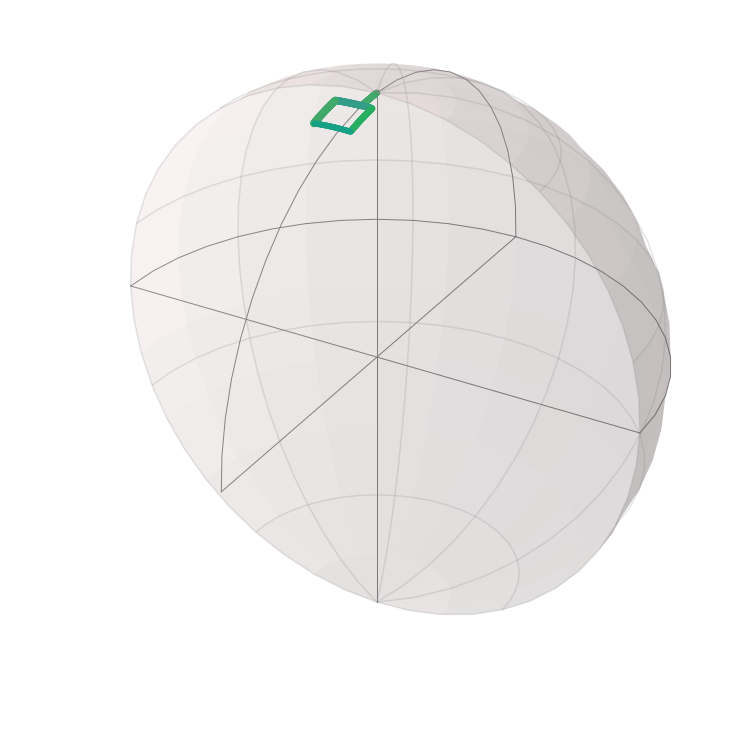

In [17]:
visualize_transition(pc_circuit,trace=True,saveas=f'animations/time.{t}.depth4.mp4', fpg=50, spg=2)

IndexError: list index out of range

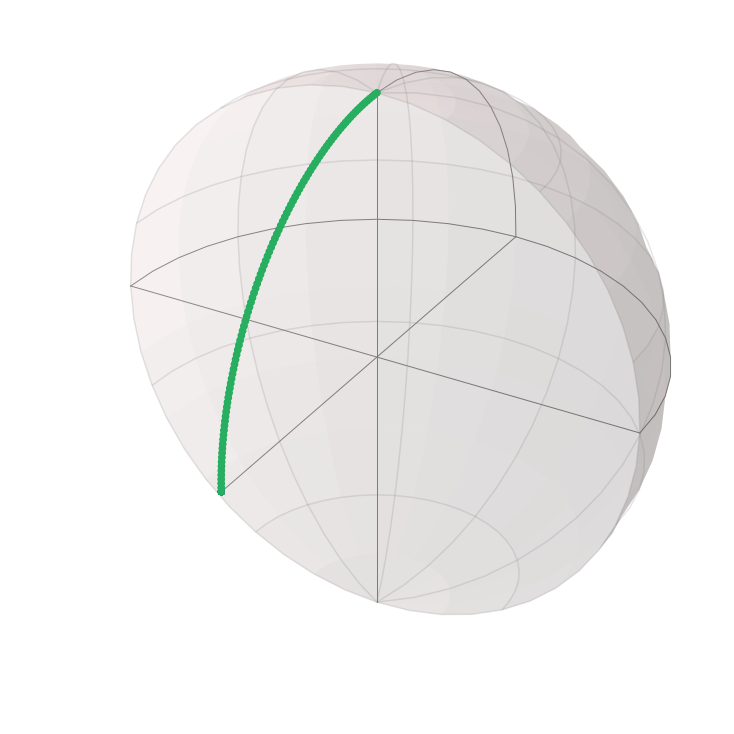

In [15]:
visualize_transition(st_circuit,trace=True,saveas=f'animations/time.{t}.depth3.mp4', fpg=100, spg=2)